In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [39]:
index = '^CNXIT'
start = '2020-10-01'
end = '2023-10-01'
index_data = yf.download(index,start=start,end=end,interval='1mo')

[*********************100%***********************]  1 of 1 completed


In [6]:
df = pd.DataFrame()
df['Close']=index_data['Close']
df.reset_index(inplace=True)
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Month'] = df['Month'].apply(lambda x: datetime(2022, x, 1).strftime('%B'))
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Direction'] = (df['Close'] > df['Close'].shift(1)).map({True: 1, False: 0})
df.head(20)

,Date,Close,Month,Year,Direction
0,2007-10-01,4793.649902,October,2007,0
1,2007-11-01,4431.149902,November,2007,0
2,2007-12-01,4812.600098,December,2007,1
3,2008-01-01,3838.149902,January,2008,0
4,2008-02-01,3984.500000,February,2008,1
5,2008-03-01,3704.949951,March,2008,0
6,2008-04-01,4357.649902,April,2008,1
7,2008-05-01,4688.350098,May,2008,1
8,2008-06-01,3999.399902,June,2008,0
9,2008-07-01,3752.850098,July,2008,0


In [7]:
mo_order = df.iloc[:12,2].values

In [9]:
del(df['Date'])
del(df['Close'])
del(df['Year'])
df.head()

,Month,Direction
0,October,0
1,November,0
2,December,1
3,January,0
4,February,1


In [10]:
X = df.iloc[:,:-1].values
Y= df.iloc[:,-1].values

In [11]:
Y = Y.reshape(-1,1)

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#apply onehot encoding to column 1 to transform categorical data into a numeric value
encoder = OneHotEncoder(sparse=False, drop='first')
ct = ColumnTransformer(transformers=[('encoder',encoder,[0])],remainder='passthrough')
X=np.array(ct.fit_transform(X))

/home/glen/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [14]:
# Training the Logistic Regression model on the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

/home/glen/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 1 23]
 [ 4 18]]


0.41304347826086957

In [16]:
pred = classifier.predict(ct.fit_transform(X[:12,:]))
print(np.concatenate((mo_order.reshape(len(mo_order),1), pred.reshape(len(pred),1)),1))

[['October' 1]
 ['November' 0]
 ['December' 1]
 ['January' 1]
 ['February' 1]
 ['March' 1]
 ['April' 1]
 ['May' 1]
 ['June' 1]
 ['July' 1]
 ['August' 1]
 ['September' 1]]


/home/glen/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<Axes: xlabel='Date'>

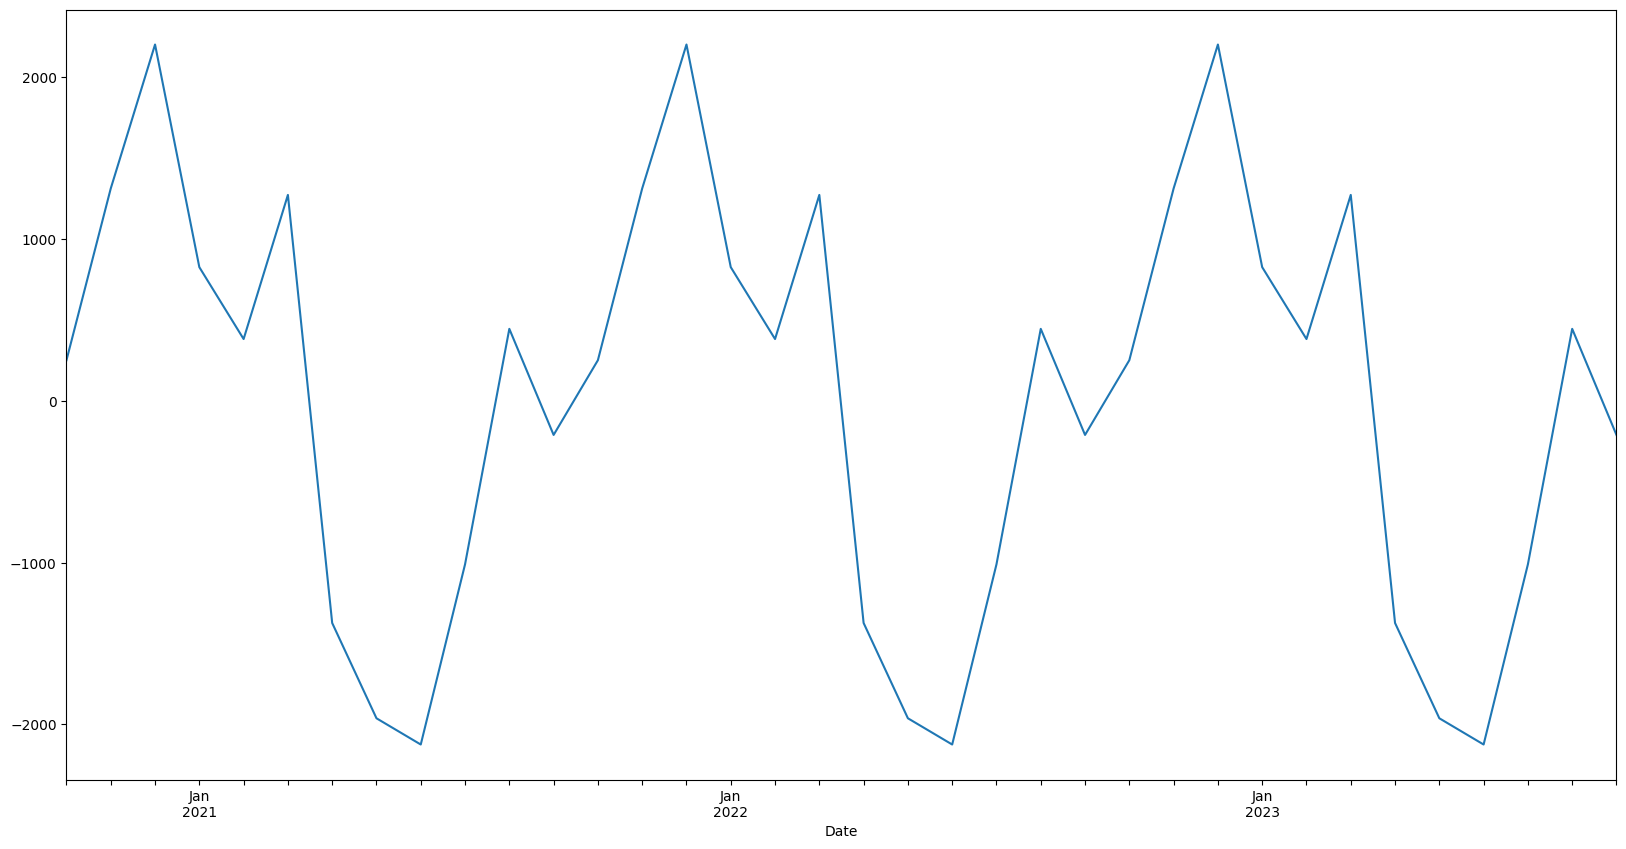

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
decomposition = seasonal_decompose(index_data['Close'], model='additive', period=12)
# 'model' can be 'additive' or 'multiplicative', depending on your data
x_ticks = pd.date_range(start=start, end=end, freq='M')
plt.xticks(x_ticks, rotation=45)
decomposition.seasonal.plot(figsize=(20,10),xticks=x_ticks)

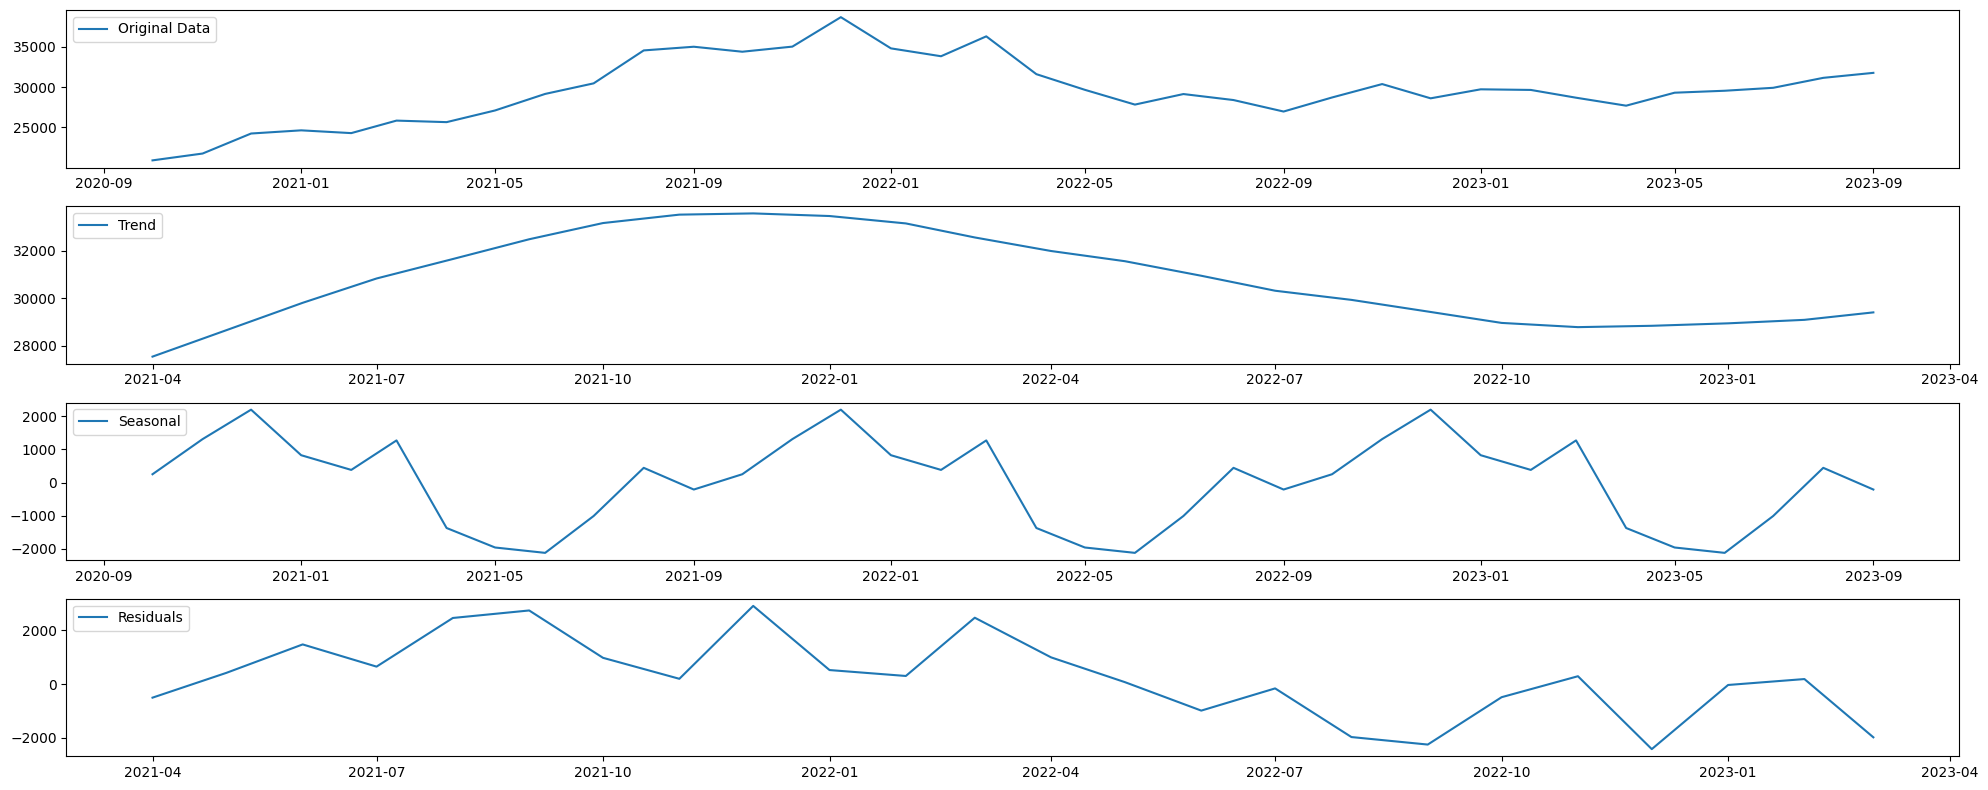

In [45]:

# Plot the decomposed components
plt.figure(figsize=(20, 8))
plt.subplot(411)
plt.plot(index_data['Close'], label='Original Data')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
